In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter
import matplotlib.ticker as mtick
%matplotlib inline

In [ ]:
def fileO(x,y,filename):
    f = open(filename,'w');
    #f = open(filename,'a'); # overwrite
    for i in range(len(y)):
        f.write('%.4e\t%.4e\n'%(x[i],y[i]));
    f.close();

In [ ]:
def fileI(filename):
    tmp = []
    f = open(filename,'r');
    lines = f.readlines()
    for line in lines:
        tmp.append(line);
    out=np.zeros([len(tmp),2]);
    for i in range(len(out)):
        out[i,:] = np.array(tmp[i].split()).astype(np.float64)
    return out;

In [3]:
# SDOF Transient Response (ISO 18431-4)
# th_in : acceleration time history at base
# th_out : acceleration time history at mass
def SDOF_ISO(th_in,dt,fn,zeta):

    wn = 2*np.pi*fn;
    wd = wn*np.sqrt(1-zeta**2);
    A=wn*dt*zeta;
    B=wd*dt;
    
    a, b = np.zeros(3), np.zeros(3);

    b[0] = 1 - np.exp(-A)*np.sin(B)/B;
    b[1] = 2*np.exp(-A)*(np.sin(B)/B - np.cos(B));
    b[2] = np.exp(-2*A) - np.exp(-A) * np.sin(B)/B;

    a[0] = 1;
    a[1] = -2*np.exp(-A)*np.cos(B);
    a[2] = np.exp(-2*A);

    th_out=lfilter(b, a, th_in, axis=-1, zi=None);
    
    return th_out;

In [4]:
# SDOF Transient Response (Newmark)
# th_in : acceleration time history at base
# th_out : acceleration time history at mass
def SDOF_newmark(th_in,dt,fn,zeta):
    def newmark_parameter(dt):
        r = 0.005; alpha = (1/4)*((1+r)**2); delta = 0.5 + r;
        a = np.zeros(8);
        a[0] = 1/(alpha*dt*dt); a[1] = delta/(alpha*dt); a[2] = 1/(alpha*dt); a[3] = 1/(2*alpha)-1;
        a[4] = delta/alpha - 1; a[5] = (dt/2)*((delta/alpha)-2); a[6] = dt*(1-delta); a[7] = delta*dt;
        return a;
    def DERIV(X,Y):
        N = len(Y); YY = np.zeros(N);
        YY[0] = (Y[1]-Y[0])/(X[1]-X[0]); Y[N-1] = (Y[N-1]-Y[N-2])/(X[N-1]-X[N-2]);
        for n in range(N-2):
            YY[n+1] = (((Y[n+2]-Y[n+1])/(X[n+2]-X[n+1]))*(X[n+1]-X[n]) + ((Y[n+1]-Y[n])/(X[n+1]-X[n]))*(X[n+2]-X[n+1]))/(X[n+2]-X[n]);
        return YY;
    def INTEG(X,Y,C1):
        N = len(Y); YY = np.zeros(N);
        YY[0] = C1;
        for n in range(1,N):
            YY[n] = YY[n-1] + (1/2)*(Y[n]+Y[n-1])*(X[n]-X[n-1]);
        return YY;      
    a = newmark_parameter(dt);
    u,v,ac = np.zeros(len(th_in)),np.zeros(len(th_in)),np.zeros(len(th_in));
    ru,rv,rac = np.zeros(len(th_in)),np.zeros(len(th_in)),np.zeros(len(th_in));
    N = len(th_in);
    time = np.arange(N)*dt;
    vth = INTEG(time,th_in,0); dth = INTEG(time,vth,0);
    F = -th_in;
    wn = 2*np.pi*fn; m = 1; c = 2*zeta*wn; k = wn**2;            
    Fe = a[0]*m + a[1]*c + k;          
    for n in range(len(th_in)-1):
        ru[n+1] = (F[n+1] + m*(a[0]*ru[n]+a[2]*rv[n]+a[3]*rac[n])+c*(a[1]*ru[n]+a[4]*rv[n]+a[5]*rac[n]))/Fe;
        rv[n+1] = a[1]*(ru[n+1]-ru[n]) - a[4]*rv[n] - a[5]*rac[n];
        rac[n+1] = a[0]*(ru[n+1]-ru[n]) -a[2]*rv[n] - a[3]*rac[n];
    th_out= rac + th_in;
    return th_out

In [36]:
# SDOF Transient Response (Smallwood)
# th_in : acceleration time history at base
# th_out : acceleration time history at mass
# out_opt : 1 = absolute acceleration / 2 = relative displacement
def SDOF_smallwood(th_in,dt,fn,zeta,out_opt):
    
    wn = 2*np.pi*fn;
    wd = wn*np.sqrt(1-zeta**2);
    a, b = np.zeros(3), np.zeros(3);
    E=np.exp(-zeta*wn*dt);
    E2=np.exp(-2*zeta*wn*dt);
    K=wd*dt;
    C=E*np.cos(K);
    P=2*zeta**2-1
    S=E*np.sin(K);
    Sp = S/K;
    if out_opt ==1:

        b[0] = 1 - Sp;
        b[1] = 2*(Sp-C);
        b[2] = E**2 - Sp;

        a[0] = 1;
        a[1] = -2*C;
        a[2] = E**2;

        th_out=lfilter(b, a, th_in, axis=-1, zi=None);
    else:
        a[0]=1         
        a[1]=-2*C
        a[2]=+E**2    
        
        b00=2*zeta*(C-1)
        b01=S*wn/wd*P
        b02=wn*dt
            
        b10=-2*wn*dt*C
        b11= 2*zeta*(1-E2)
        b12=-2*b01   
    
        b20=(2*zeta+wn*dt)*E2
        b21= b01
        b22=-2*zeta*C               
            
        b[0]=b00+b01+b02
        b[1]=b10+b11+b12
        b[2]=b20+b21+b22
            
        b=-b/(wn**3*dt)
        
        th_out=lfilter(b, a, th_in, axis=-1, zi=None);
        th_out *=386.4;
    return th_out;       

In [6]:
# ft = freqeuncy table / th = input time history / damp = damping ratio 
# dt = integration time step (default = 1/(20*fmax))
# input unit = base acceleration (g)
# output unit = absolute acceleration (g) 

In [7]:
## SRS (Newmark Method)
def srs_nm(ft,th,dr,dt):
    nf = len(ft);
    rs = np.zeros(nf);
    for i in range(nf):
        rs[i]= max(abs(SDOF_newmark(th,dt,ft[i],dr)));
    return ft,rs;

In [8]:
## SRS (Smallwood Method)
def srs_sw(ft,th,dr,dt):
    nf = len(ft);
    rs = np.zeros(nf);
    for i in range(nf):
        rs[i]= max(abs(SDOF_smallwood(th,dt,ft[i],dr,1)));
    return ft,rs;

In [32]:
## SRS (Smallwood Method) - Pseudo Acceleration Output
def srs_sw_pa(ft,th,dr,dt):
    nf = len(ft);
    rs = np.zeros(nf);
    for i in range(nf):
        rs[i]= ((2*np.pi*ft[i])**2)*max(abs((SDOF_smallwood(th,dt,ft[i],dr,2))))/386.4;  
    return ft,rs;

In [10]:
## SRS (ISO 18431-4)
def srs_iso(ft,th,dr,dt):
    nf = len(ft);
    rs = np.zeros(nf);
    for i in range(nf):
        rs[i]= max(abs(SDOF_ISO(th,dt,ft[i],dr)));
    return ft,rs;

In [11]:
## Sample Time History
ft = np.linspace(1,1000,1000)/10;  dt = 1/(20*max(ft));  damp = 0.01;
t = np.arange(10001)*dt;
gth = 10*np.sin(2*np.pi*t) + 13*np.sin(2*np.pi*3*t+np.pi/1.3) + 17*np.sin(2*np.pi*5*t+np.pi/1.7);

In [34]:
# freq,rs_nm = srs_nm(ft,gth,damp,dt);
freq,rs_sw = srs_sw(ft,gth,damp,dt);
freq,rs_iso = srs_iso(ft,gth,damp,dt);

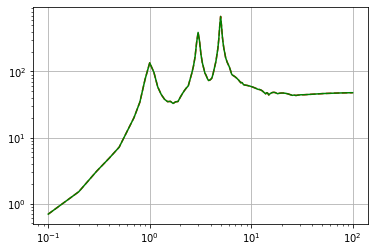

In [35]:
# plt.plot(freq,rs_nm,'b-.'); 
plt.plot(freq,rs_sw,'r--'); 
plt.plot(freq,rs_iso,'g-');
plt.xscale('log'); plt.yscale('log');
plt.grid();

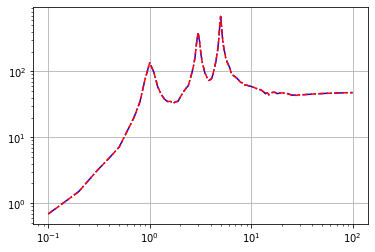

In [37]:
freq,rs_sw = srs_sw(ft,gth,damp,dt);
freq,rs_sw_pa = srs_sw_pa(ft,gth,damp,dt);
plt.loglog(freq,rs_sw,'b-.'); 
plt.loglog(freq,rs_sw_pa,'r--'); 
plt.grid();

In [14]:
## Half Sine 예제 Exact Solution과 비교 추가

In [ ]:
## Elcentro 예제 추가

In [14]:
gth = fileI('elcentro.dat');
dt = gth[1,0] - gth[0,0];

In [24]:
ft = np.logspace(-1,2,100); damp=1/20;

In [25]:
freq,rs_iso = srs_iso(ft,gth[:,1],damp,dt);

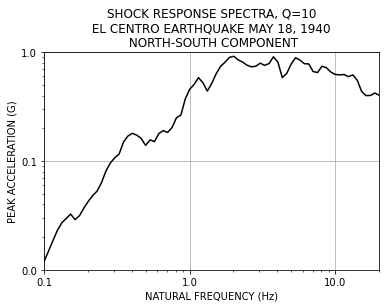

In [31]:
plt.plot(freq,rs_iso,'k-');
plt.xscale('log'); plt.yscale('log');
plt.xlim([0.1,20]); plt.ylim([0.01,1]);
plt.title('SHOCK RESPONSE SPECTRA, Q=10\n EL CENTRO EARTHQUAKE MAY 18, 1940 \n NORTH-SOUTH COMPONENT');
plt.xlabel('NATURAL FREQUENCY (Hz)');
plt.ylabel('PEAK ACCELERATION (G)');
plt.gca().xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f')); 
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'));
plt.grid();